# Clone code từ github và chuẩn bị môi trường

In [ ]:
!git clone https://github.com/duybui1911/AI_CHALLENGE_sample.git

In [ ]:
%cd /content/AI_CHALLENGE_sample

#### Cài các thư viện cần thiết nè, cài mất tầm 5m gì đó. Đặt đây rồi đi pha cốc coffee xong là vừa :V

In [ ]:
!pip3 install -r requirements.txt

In [ ]:
from threading import Thread
from typing import Iterator

import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, TextIteratorStreamer

from tools.utils import use_calculator
from dataset import get_data, TestDataset

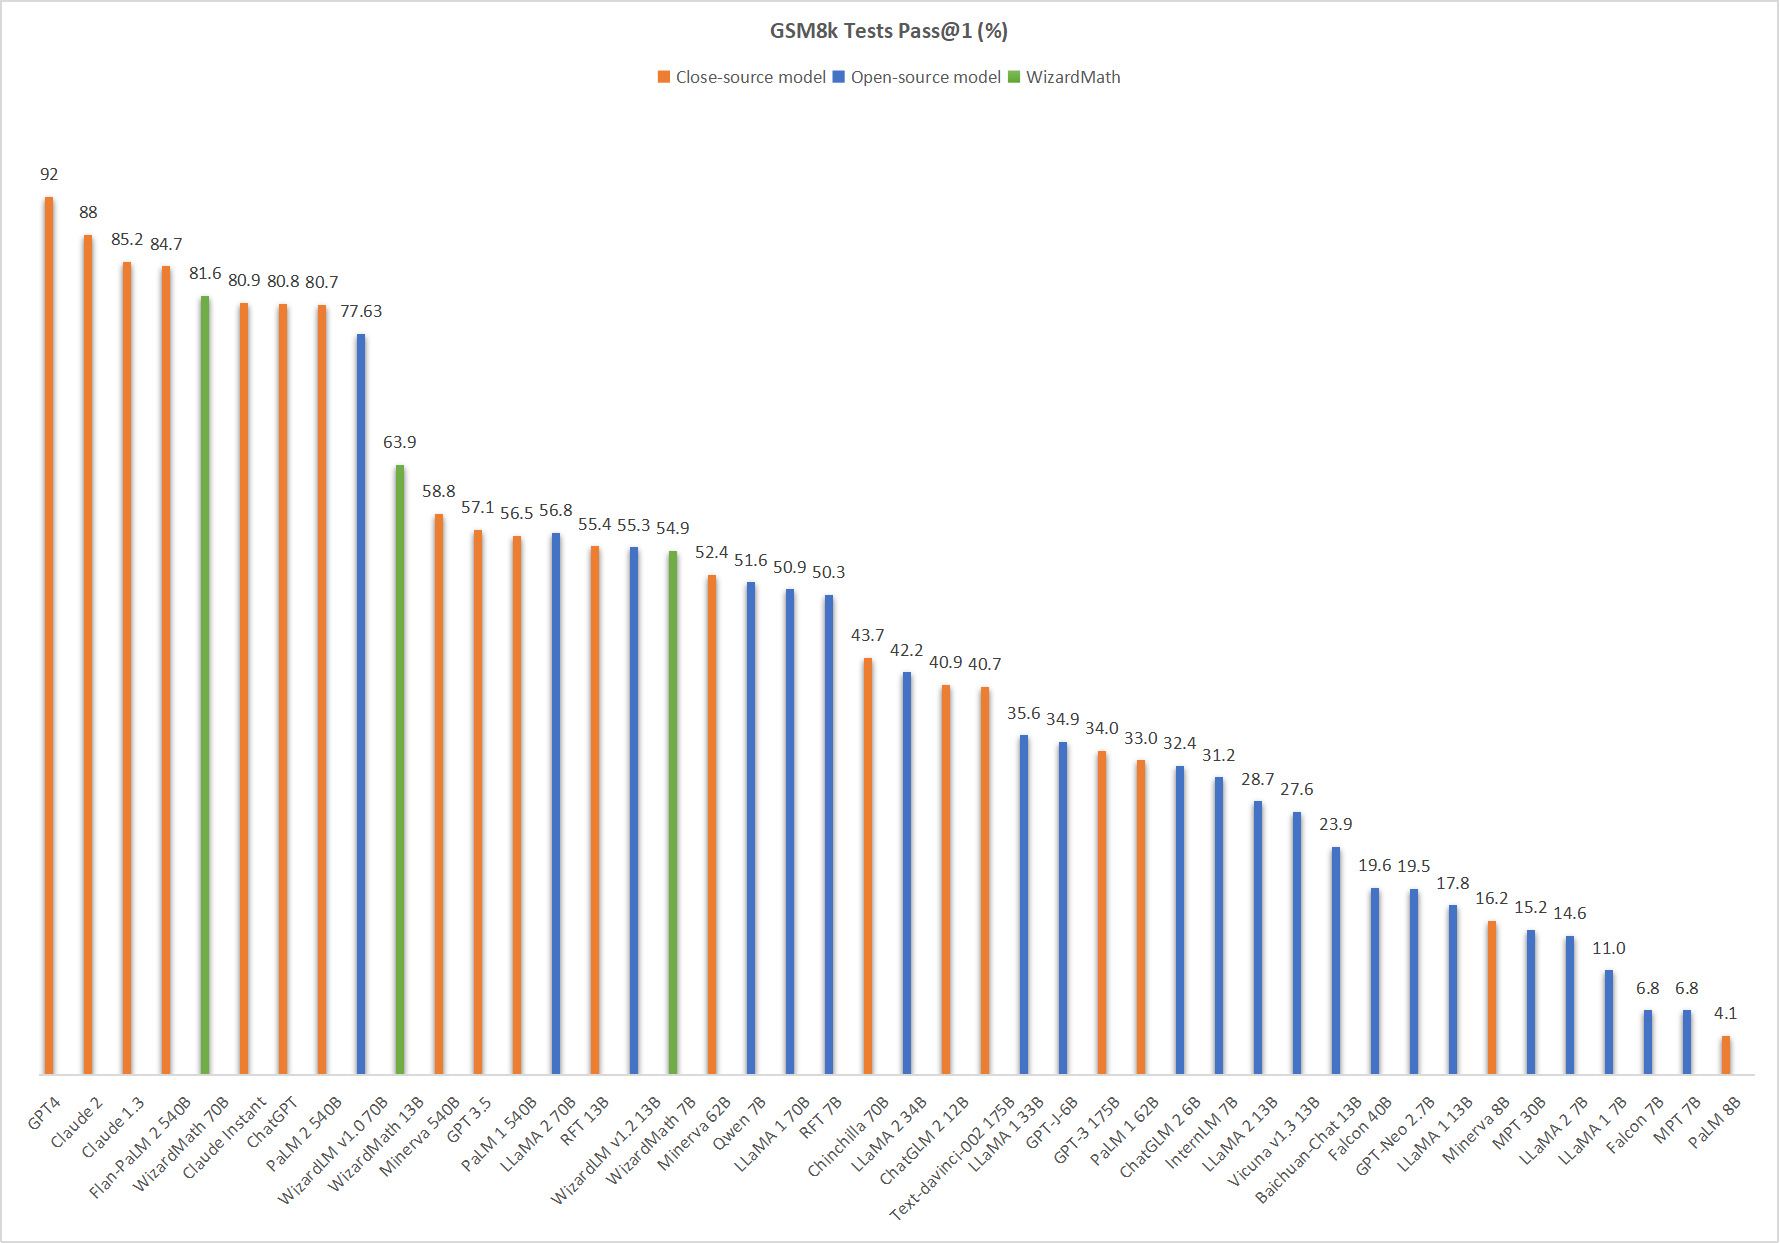

# Load model từ huggingface, Như các bạn thấy ở hình thì đây là 1 mô hình mình thấy khá ổn so với các model đồng trang lứa =))))
### Lưu ý 1: trước khi load model thì nên đăng nhập vô huggingface trước cho đỡ lỗi nha các bro :v
### Link đăng nhập: <https://huggingface.co/login>

### Lưu ý 2: Do mình soạn hướng dẫn này với bản colab dùng chùa nên bị giới hạn nhiều về VRAM, vì vậy mình load model chỉ với float16. Điều này sẽ làm giảm tính chính xác 1 chút của mô hình, nếu bạn nào nạp VJP thì có thể để lên float32 or float64 nhé 🧛


### Lưu ý 3: Load model lâu vch nên lần này uống xong coffee thì kiếm chỗ nào buôn chuyện tầm 10m rồi quay lại :v

In [ ]:
model_name = 'WizardLM/WizardMath-7B-V1.0'
if torch.cuda.is_available():
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        torch_dtype=torch.float16,
        device_map='auto'
    )
else:
    model = None
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Sau khi load model thành công thì chạy các hàm để gọi kết quả như sau

### Hàm config prompt cho model

In [ ]:
def get_prompt(message: str, chat_history: list[tuple[str, str]],
               system_prompt: str) -> str:
    texts = [f'[INST] <<SYS>>\n{system_prompt}\n<</SYS>>\n\n']
    #for user_input, response in chat_history:
    #    texts.append(f'{user_input.strip()} [/INST] {response.strip()}[INST] ')
    texts.append(f'{message.strip()} [/INST]')
    return ''.join(texts)

### Hàm thực thi chính khi run model

In [ ]:
def run(message: str,
        chat_history: list[tuple[str, str]],
        system_prompt: str,
        max_new_tokens: int = 100,
        temperature: float = 0.5,
        top_p: float = 0.95,
        top_k: int = 50) -> Iterator[str]:
    prompt = get_prompt(message, chat_history, system_prompt)
    inputs = tokenizer([prompt], return_tensors='pt').to("cuda")

    streamer = TextIteratorStreamer(tokenizer,
                                    timeout=10.,
                                    skip_prompt=True,
                                    skip_special_tokens=True)
    generate_kwargs = dict(
        inputs,
        streamer=streamer,
        max_new_tokens=max_new_tokens,
        do_sample=True,
        top_p=top_p,
        top_k=top_k,
        temperature=temperature,
        num_beams=1,
    )
    t = Thread(target=model.generate, kwargs=generate_kwargs)
    t.start()

    outputs = []
    for text in streamer:
        outputs.append(text)
        yield ''.join(outputs)

### Hàm gọi và gen kết quả

In [ ]:
def generate(
    message: str,
    history_with_input: list[tuple[str, str]],
    system_prompt: str,
    max_new_tokens: int,
    top_p: float,
    temperature: float,
    top_k: int,
) -> Iterator[list[tuple[str, str]]]:

    history = history_with_input[:-1]
    generator = run(message, history, system_prompt, max_new_tokens,
                    temperature, top_p, top_k)
    try:
        first_response = next(generator)
        yield history + [(message, first_response)]
    except StopIteration:
        yield history + [(message, '')]
    for response in generator:
        yield history + [(message, response)]

In [ ]:
def process_example(message: str,
                    system_prompt: str,
                    max_new_tokens: int,
                    top_p: float,
                    temperature: float,
                    top_k: int,) -> tuple[str, list[tuple[str, str]]]:
    generator = generate(
                          message= message,
                          history_with_input= [],
                          system_prompt= system_prompt,
                          max_new_tokens= max_new_tokens,
                          top_p= top_p,
                          temperature= temperature,
                          top_k= top_k,
                          )
    for x in generator:
        pass
    return '', x

### Hàm convert từ kết quả model gen ra sang định dạng file nộp

In [ ]:
# Input dạng: 'The answer is: 80.' và chuỗi options
# Output sẽ là đáp án chứa 80 hoặc 80 nếu options = ""
import re
def convert_to_submit_file(api_result: str = '', options: str = ''):
    api_result = ((api_result.replace('/s', '')).replace('\n', '')).replace(' ', '')
    api_result = re.sub(r'[^a-zA-Z0-9.:\\)]', '', api_result)
    answer_start = api_result.lower().find(":")
    if answer_start != -1:
        if api_result[-1] == '.':
            api_result = api_result[:-1]
        answer_part = api_result[answer_start + 1:].strip()
        if any(c.isalpha() for c in answer_part):
            answer = answer_part[0:answer_part.find(")")]
            answer =  answer.lower()

        else:
            answer = answer_part.lower()

        if options != '':
            options = options.lower().replace(" ", "")
            if is_number(answer):
              answer_id = options.find(str(answer))
              character_id = options.rfind(')', 0, answer_id)
              answer = options[character_id-1]
            else:
              answer = answer
            #for option in options_lower.split(','):
            #    if ' ' + option.strip() + ' ' in api_result.lower():
            #        return option.strip()
        return answer

    return 'Nan'

def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

### Sửa link dữ liệu ở đây nhé, tuy nhiên mình khuyên nên dùng luôn folder data và nếu sử dụng ảnh thì upload luôn lên đó.

#### Lại 1 cái lưu ý nữa: Do model nặng rồi với cả colab không cho load file json quá nặng đâu. Nên các bạn nên chạy số lượng câu nhỏ hơn **30K** dòng nhé. Như thế thì file test sẽ phải chia ra làm 3 file rồi khi xong thì nối các file vào 1 để submit, mình cũng chia luôn cho các bạn rồi đấy ✌

#### **Lưu ý cuối cùng 1:** Sau khi chạy xong file test nào thì download luôn file kết quả đó về rồi nhé, đề phòng trường hợp các bạn may mắn bị anh gg ngắt giữa chừng thì bay mất gói coffee  =)))))))))
#### File kết quả tương ứng là: results1.txt cho test1.json, ..., nối file results1.txt, results2.txt, results2.txt lần lượt từ trên xuống thành 1 file tổng results.txt xong zip lại là okii rùi

In [ ]:
data_link = './data/'

In [ ]:
file_names = ['test1.json', 'test2.json', 'test3.json']

In [ ]:
import time
import os
from google.colab import files

for file_id, file_name in enumerate(file_names):
    submit_list = []
    test_examples = get_data(os.path.join(data_link, file_name))
    with open(f'./results/results{file_id+1}.txt', 'w') as f:
        for problem in test_examples:
            # Thay đổi prompt của các bạn ở đây, nên tạo prompt hướng vẫn và chia nhỏ các chủ đề để
            # kết quả được tốt hơn.
            # Lưu ý: Mình chưa xử lý phần ảnh, nên các bạn có thể xử lý thêm vào phần này rồi nối vào prompt hoặc ques

            prompt = "Help me choose the correct answer to the following problem."
            if problem["options"] != "":
                prompt += " Note: you only need to provide the letter that precedes the correct answer. For example: a). Here is the question:"
            else:
              prompt += " Note: you only need to give the correct answer. For example: 10. Here is the question:"
            ques = '\nQuestion:' + problem["Problem"]
            max_len = 15
            sys_rq = prompt + ques
            try:
                start = time.time()
                answer = process_example(
                        message= ques,  # Cái này là câu hỏi và options
                        system_prompt= prompt, # Cái này là hướng dẫn nó
                        max_new_tokens = max_len, # Đây là độ dài tối đa của phần model trả về
                        top_p= 0.9, # 3 tham số này các bạn xem lại buổi 2 mình có nói rồi nhé
                        temperature= 0.5,
                        top_k= 200
                )
                _, answer = answer[1][0]
                end = time.time()
                submit_item = convert_to_submit_file(answer, problem["options"])
                submit_list.append(submit_item)
            except Exception as e:
                submit_list.append('Nan')
                print(e)
            print(f"Test {file_id+1}\tTime {problem['id']}: {end-start}, answer: {submit_item}")
            f.write(submit_list[-1] + '\t' + str(end-start) + '\n')
    print(f'\n-------------------------------------------\nEND test{file_id+1}.json\n-------------------------------------------\n')


### **Lưu ý cuối cùng 2:** Thi thoảng xóa cái nó chạy gen ra màn hình đi và thi thoảng tương tác với giao diện của colab cái không bỏ lâu nó dỗi nó ngắt kết nối là đi tong đấy. Ny mà mình bơ còn bị đá nữa là đang dùng chùa :v  

## Chúc các bạn chạy không bug và đượt kết quả tốt :v